### Final Project for Cosmology with Zoltan Haiman @ Columbia

By Fred Angelo Garcia 

In this notebook, I will, using WMAP data, extract cosmological parameters $\Omega_b$ (baryon fraction), $\Omega_{\rm DM}$ (dark matter fraction), $\Omega_{\rm k}$ (the flattness parameter), and the ratio of the comological constant and the critical density $\Omega_{\Lambda}$. Below,  the general procedure was to allow $\Omega_b$, $\Omega_{\rm DM}$, $\Omega_{\rm k}$, to vary in the CAMBS model, while keeping $H_0$ fixed. The best fit values for $\Omega_b$ and $\Omega_{\rm DM}$ was then used to find the best $\Omega_{\Lambda}$ value. 

I used a popular Makov-Chain Monte-Carlo package in python called, $\texttt{emcee}$. 
The likelihood function which I numerically minimized is the 
$\chi^2$ between the output model and the data (and its given errors).

Note, that the general procedure in MCMC is to intialize random "walkers", which encapsualtes your priors-- what you know about the data, for me, the prior were taken from the WMAP paper (https://arxiv.org/pdf/1212.5226); i.e., the value I was fitting were rougly around the reported values. These walkers then "walk" around the true value until the log probability is minimused. For the walkers themselves I used a normal distributed prior around said value. The number of walkers and steps used in this study depended on the time constrants. 

Nonetheless, we get the following best fit parameters using this approach, which could have used more computational time to really constrain the values. Please see the bottom of the notebook for the best fit plots. However, these were the final values I have computed using this approach.


$\Omega_b$ = $0.050_{-0.019}^{0.023}$
$\Omega_{\rm DM}$ = $0.211_{-0.081}^{0.120}$
$\Omega_{\rm k}$ = $-0.008_{-0.295}^{0.315}$
$\Omega_{\Lambda}$ = $0.732_{-0.131}^{0.089}$

Thank you, Marguerite!

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower
import emcee
import corner

In [5]:
# download the data from
# https://lambda.gsfc.nasa.gov/data/map/dr5/dcp/spectra/wmap_tt_spectrum_9yr_v5.txt
# and read it in

data = np.loadtxt("./wmap_tt_spectrum_9yr_v5.txt")

# the data has Columns
# multipole l,
# TT spectrum,
# error derived from diagonal elements of the covariance matrix,
# portion of it comming from measurement,
# portion comming from cosmic variance

l_data = data[:, 0]
TT = data[:, 1]
err1 = data[:, 2]
err2 = data[:, 3]
err3 = data[:, 4]

print(l_data.min(), l_data.max())
print(l_data)
print(l_data.shape)

2.0 1200.0
[   2.    3.    4. ... 1198. 1199. 1200.]
(1199,)


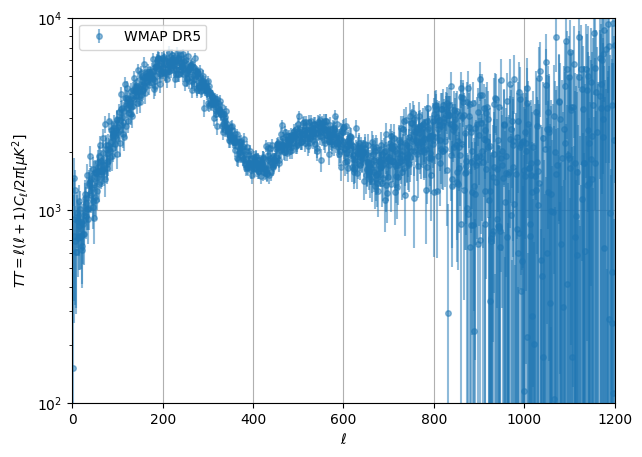

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.errorbar(l_data, TT, yerr=err1, fmt="o", label="WMAP DR5", alpha=0.5, markersize=4)
ax.set(
    xlabel=r"$\ell$",
    ylabel=r"$TT = \ell(\ell+1)C_\ell/2\pi [\mu K^2]$",
    xlim=(0, 1200),
    ylim=(100, 10000),
    yscale="log",
)
ax.grid()
ax.legend()
plt.show()

Here, throughout this analysis, we adopt the following when noted, from [Hinshaw et al](https://arxiv.org/pdf/1212.5226)

### now see how CAMB works

used this tutorial notebook as a starting point 
https://camb.readthedocs.io/en/latest/CAMBdemo.html

<img src="./henshaw_etal.png" alt="Example Image" width="500" />


In [7]:
wmap_omegab = 0.0464
wmap_omegac = 0.235
zoltan_H0 = 72


def model_TT(omega_baryon=0.0464, omega_coldDM=0.235, omega_k=0, H0=72, lmax=1200):

    h = H0 / 100.0

    # from the Wmap 7 year results
    ombh2 = omega_baryon * h**2
    omch2 = omega_coldDM * h**2
    Omega_matter = omega_baryon + omega_coldDM

    pars = camb.set_params(
        H0=H0,  # Hubble parameter today
        ombh2=ombh2,  # physical baryon density
        omch2=omch2,  #  physical density in cold dark atter
        omk=omega_k,  # flat, Omega_K curveture parameter
        mnu=0,  # sum of neutrino masses
        lmax=1200,
    )
    results = camb.get_results(pars)

    # part of resultsreults
    # print(results)
    # print(results.omega_de)
    # derived_params = results.get_derived_params()
    # print(derived_params["omega_da"])
    # get dictionary of CAMB power spectra

    powers = results.get_cmb_power_spectra(
        pars,
        CMB_unit="muK",
        lmax=lmax,
    )

    # plot the total lensed CMB power spectra versus unlensed, and fractional difference
    totCL = powers["total"]
    unlensedCL = powers["unlensed_scalar"]

    # print(totCL.shape)
    # Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
    # The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).\

    totCL = totCL[:, :]
    unlensedCL = unlensedCL[:, :]
    ls = np.arange(totCL.shape[0])

    # print(totCL.shape)

    # our data starts at 2, so we need to remove the first two elements
    return ls[2:], totCL[2:], unlensedCL[2:], results.omega_de


ls, totCL, unlensedCL, omega_lambda = model_TT(
    omega_baryon=0.0464, omega_coldDM=0.235, omega_k=0, H0=72
)

[   2    3    4 ... 1198 1199 1200]


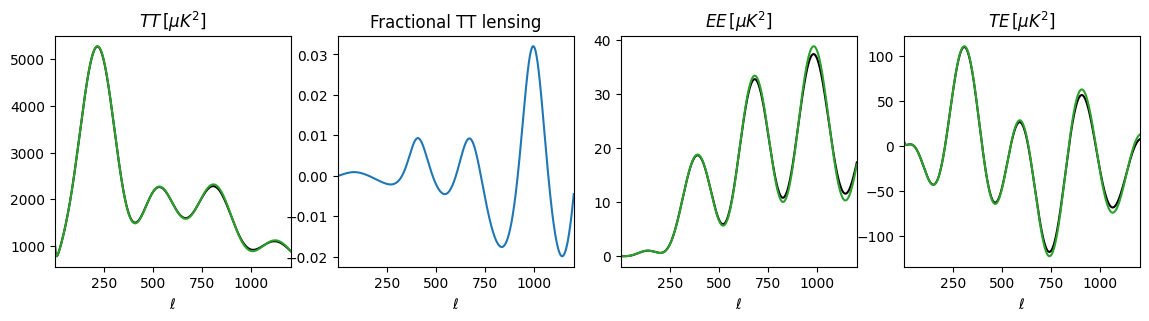

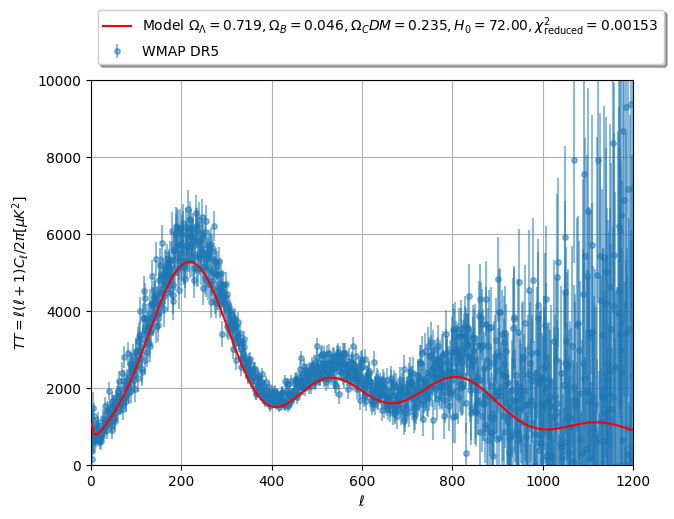

In [8]:
def ch2(data, model, error):
    """standard chi squared function

    Args:
        data (_type_):  data points from wmap
        model (_type_):  CAMB model
        error (_type_): error in the data

    Returns:
        _type_: _description_
    """
    return np.sum((data - model) ** 2 / error**2) / len(data)


def reduced_ch2(data, model, error, n_params):
    return ch2(data, model, error) / (len(data) - n_params)


fig, ax = plt.subplots(1, 4, figsize=(14, 3), dpi=100)
print(ls)
ax[0].plot(ls, totCL[:, 0], color="k")
ax[0].plot(ls, unlensedCL[:, 0], color="C2")
ax[0].set_title(r"$TT\, [\mu K^2]$")
ax[1].plot(ls[2:], 1 - unlensedCL[2:, 0] / totCL[2:, 0])
ax[1].set_title(r"Fractional TT lensing")
ax[2].plot(ls, totCL[:, 1], color="k")
ax[2].plot(ls, unlensedCL[:, 1], color="C2")
ax[2].set_title(r"$EE\, [\mu K^2]$")
ax[3].plot(ls, totCL[:, 3], color="k")
ax[3].plot(ls, unlensedCL[:, 3], color="C2")
ax[3].set_title(r"$TE\, [\mu K^2]$")
for ax in ax.reshape(-1):
    ax.set_xlim([2, 1200])
    ax.set_xlabel(r"$\ell$")

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

initial_chi2 = ch2(TT, totCL[:, 0], err1)
initial_reduced_chi2 = reduced_ch2(TT, totCL[:, 0], err1, 3)

ax.errorbar(
    l_data,
    TT,
    yerr=err1,
    fmt="o",
    label="WMAP DR5",
    alpha=0.5,
    markersize=4,
)
ax.set(
    xlabel=r"$\ell$",
    ylabel=r"$TT = \ell(\ell+1)C_\ell/2\pi [\mu K^2]$",
    xlim=(0, 1200),
    ylim=(0, 10000),
)
ax.plot(
    ls,
    totCL[:, 0],
    color="r",
    zorder=5,
    label=r"Model $\Omega_\Lambda = {:.3f}, \Omega_B = {:.3f}, \Omega_CDM = {:.3f}, H_0 = {:.2f}, \chi^2_{{\rm reduced}} = {:.5f}$".format(
        omega_lambda, wmap_omegab, wmap_omegac, zoltan_H0, initial_reduced_chi2
    ),
)
ax.grid()
ax.legend(bbox_to_anchor=(0, 1.2), loc="upper left", fancybox=True, shadow=True)
plt.show()

### here we can make functions that can determine what a good fit is

one thing to do would be to define a negative log probability. which assumes that the data's errors are gaussian. 

we have to assume a prior, which in this case, we can just assume a top hat around some acceptable range that is reasonable.

we can use the emcee package by [dfm](https://dfm.io/about/)

In [ ]:
derived_omega_lambdas = []


def log_likelihood(theta, ell, c_ell, c_ell_err):
    """log likelihood function that we will try to minimize

    Args:
        theta (_type_): array of parameters
        ell (_type_): _description_
        c_ell (_type_): _description_
        c_ell_err (_type_): _description_

    Returns:
        _type_: _description_
    """
    O_baryon, O_coldDM, O_k = theta

    ls, model, unlensedCL, omega_lambda = model_TT(O_baryon, O_coldDM, H0=72)
    derived_omega_lambdas.append(omega_lambda)
    # the different CL are always in the order TT, EE, BB, TE
    pwr_spectrum = model[:, 0]

    chisq = ch2(c_ell, c_ell_err, pwr_spectrum)
    return -0.5 * chisq


# the truth is the wmap data
omega_baryon_true = 0.0464
omega_coldDM_true = 0.235
omega_k_true = 0

# let's define the prior

# acceptable ranges
omega_baryon_acc = [omega_baryon_true - 0.1, omega_baryon_true + 0.1]
omega_coldDM_acc = [omega_coldDM_true - 0.1, omega_coldDM_true + 0.1]
omega_k_acc = [omega_coldDM_true - 0.1, omega_coldDM_true + 0.1]


# omega_lambda_acc = [0.23, 1.0]
# H0_acc = [60, 80]


def log_prior(theta):
    """log prior function that we will try to minimize

    Args:
        theta (_type_): array of parameters

    Returns:
        _type_: _description_
    """
    O_baryon, O_coldDM, O_k = theta
    if (
        omega_baryon_acc[0] < O_baryon < omega_baryon_acc[1]
        and omega_coldDM_acc[0] < O_coldDM < omega_coldDM_acc[1]
        and omega_k_acc[0] < O_k < omega_k_acc[1]
        # and O_coldDM > O_baryon
        # and O_coldDM + O_baryon == 0.26
        # and omega_lambda_acc[0] < O_lambda < omega_lambda_acc[1]
    ):
        return 0.0

    return -np.inf


def log_probability(theta, ell, c_ell, c_ell_err):
    """log probability function that we will try to minimize

    Args:
        theta (_type_): array of parameters
        ell (_type_): _description_
        c_ell (_type_): _description_
        c_ell_err (_type_): _description_

    Returns:
        _type_: _description_
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, ell, c_ell, c_ell_err)


# let's add the MCMC part
nwalkers = 50
n_iterations = 200
# uniform distribution of walkers
# omega_baryon_walkers = np.random.uniform(
#     omega_baryon_acc[0], omega_baryon_acc[1], nwalkers
# )
# omega_coldDM_walkers = np.random.uniform(
#     omega_coldDM_acc[0], omega_coldDM_acc[1], nwalkers
# )
# omega_k_walkers = np.random.uniform(
#     omega_k_acc[0], omega_k_acc[1], nwalkers
# )
# omega_lambda_walkers = np.random.uniform(
#     omega_lambda_acc[0], omega_lambda_acc[1], nwalkers
# )
# H0_walkers = np.random.uniform(H0_acc[0], H0_acc[1], nwalkers)

# normal distribution of walkers


omega_baryon_walkers = np.random.randn(nwalkers) * 0.01 + omega_baryon_true
omega_coldDM_walkers = np.random.randn(nwalkers) * 0.01 + omega_coldDM_true
omega_k_walkers = np.random.randn(nwalkers) * 0.01 + omega_k_true

# initial list of walkers
p0 = np.array([omega_baryon_walkers, omega_coldDM_walkers, omega_k_walkers]).T

In [ ]:
# sampler = emcee.EnsembleSampler(
#     nwalkers, p0.shape[1], log_probability, args=(l_data, TT, err1)
# )
# sampler.run_mcmc(p0, n_iterations, progress=True)

100%|██████████| 200/200 [1:01:18<00:00, 18.39s/it]


State([[ 0.03253385  0.26354045 -0.28708467]
 [ 0.05610798  0.26395259  0.15800075]
 [ 0.02312285  0.1700591  -0.26988809]
 [ 0.06098163  0.15363038  0.03054618]
 [ 0.020281    0.33655135 -0.16679941]
 [ 0.02727215  0.12339953 -0.28018711]
 [ 0.06115745  0.13989125 -0.31797886]
 [ 0.05034794  0.24321107  0.19721778]
 [ 0.02200255  0.10670835 -0.20689771]
 [ 0.03157147  0.27692769  0.23625451]
 [ 0.08810447  0.29071102 -0.05370039]
 [ 0.03227201  0.11245141 -0.3679735 ]
 [ 0.03177937  0.19991741 -0.13478309]
 [ 0.07941336  0.18688213 -0.40538613]
 [ 0.05808559  0.3044044  -0.04550715]
 [ 0.05830044  0.2228825   0.15374131]
 [ 0.08486366  0.23485436  0.38517764]
 [ 0.08631745  0.13486143 -0.36118316]
 [ 0.05051449  0.34114168  0.19694449]
 [ 0.05446017  0.13765035 -0.06709723]
 [ 0.02173855  0.10174494  0.26637452]
 [ 0.02779745  0.25948603  0.30704306]
 [ 0.07298477  0.12373634 -0.11574309]
 [ 0.06999478  0.26357556 -0.29124607]
 [ 0.02629375  0.24398131 -0.36452453]
 [ 0.02542007  0.13

we can look at convergence below

Text(0.5, 0, 'step number')

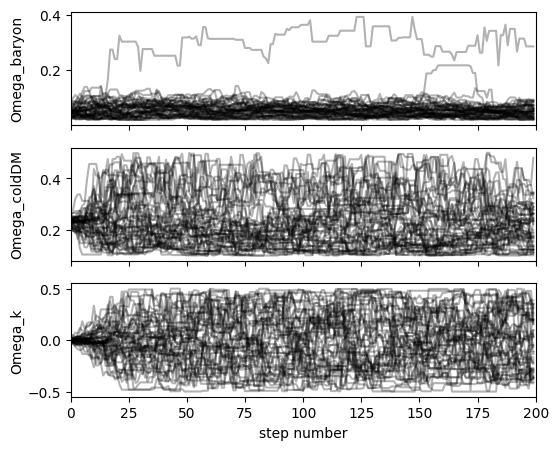

In [35]:
fig, axes = plt.subplots(3, figsize=(6, 5), sharex=True)
samples = sampler.get_chain()
labels = ["Omega_baryon", "Omega_coldDM", "Omega_k"]
for i in range(p0.shape[1]):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [33]:
def compute_omega_lambda(omega_baryon, omega_coldDM):
    """compute the derived quantity Omega_Lambda."""
    return 1.0 - omega_baryon - omega_coldDM


flat_samples = sampler.get_chain(discard=100, flat=True)
omega_lambda_derived = compute_omega_lambda(flat_samples[:, 0], flat_samples[:, 1])

# concatenate the omega_lambda_derived to the flat_samples
flat_samples = np.concatenate((flat_samples, omega_lambda_derived[:, None]), axis=1)
print(flat_samples.shape)

(5000, 4)


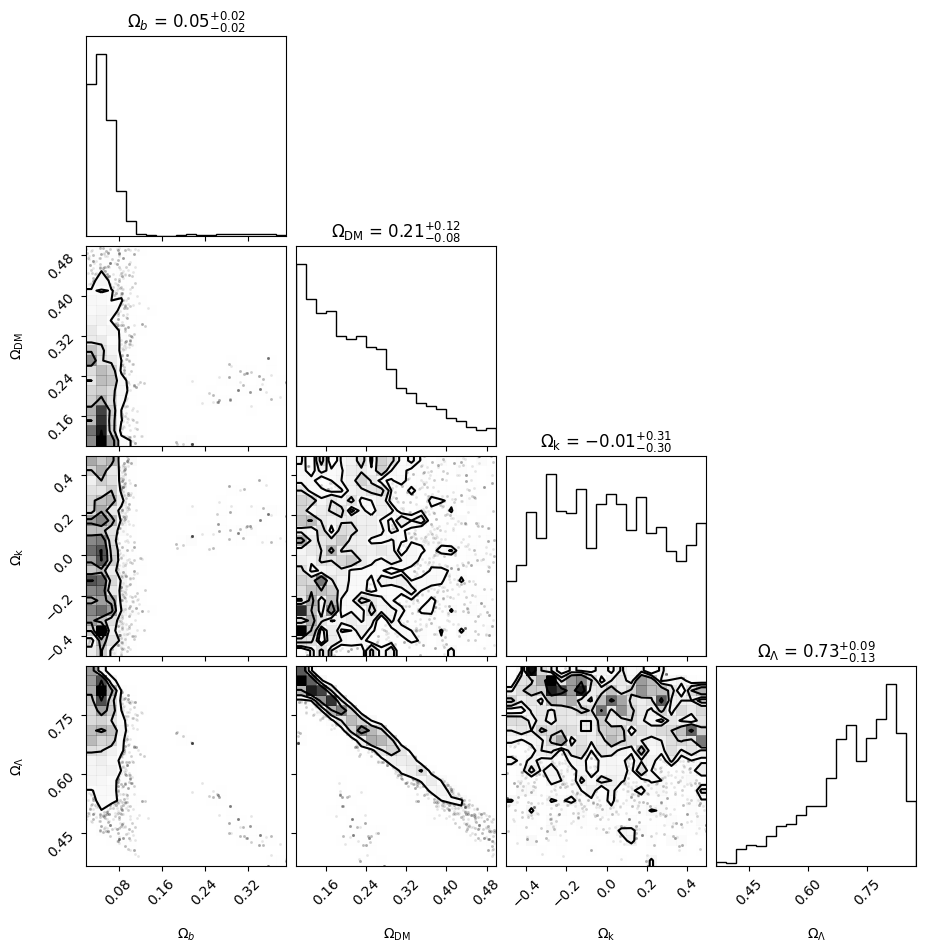

In [ ]:
labels = [
    r"$\Omega_b$",
    r"$\Omega_{ DM}$",
    r"$\Omega_{\rm k}$",
    r"$\Omega_{\Lambda}$",
]
fig = corner.corner(flat_samples, labels=labels, show_titles=True)

In [55]:
### plto the best fit model

from IPython.display import display, Math

for i in range(len(labels)):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = r"{3} = ${0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    # print(txt)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

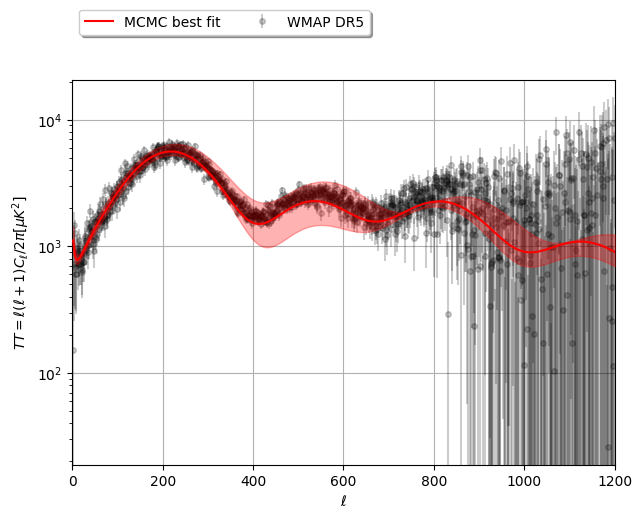

In [ ]:
# we can now generate a mock power spectrum using the best fit parameters and plot it


ls, bestfit_totCL, best_fit_unlensedCL, omega_lambda = model_TT(
    omega_baryon=0.050, omega_coldDM=0.211, omega_k=-0.008, H0=72
)
best_power_spectrum = bestfit_totCL[:, 0]

# lower and upper bounds of the best fit model

_, bestfit_totCL_low, _, _ = model_TT(
    omega_baryon=0.050 - 0.019,
    omega_coldDM=0.211 - 0.081,
    omega_k=-0,
    H0=72,
)
_, bestfit_totCL_high, _, _ = model_TT(
    omega_baryon=0.050 + 0.023,
    omega_coldDM=0.211 + 0.120,
    omega_k=-0,
    H0=72,
)


fig, ax = plt.subplots(1, 1, figsize=(7, 5))

initial_chi2 = ch2(TT, best_power_spectrum, err1)
initial_reduced_chi2 = reduced_ch2(TT, best_power_spectrum, err1, 3)

ax.errorbar(
    l_data,
    TT,
    yerr=err1,
    fmt="o",
    label="WMAP DR5",
    alpha=0.2,
    markersize=4,
    color="k",
)
ax.set(
    xlabel=r"$\ell$",
    ylabel=r"$TT = \ell(\ell+1)C_\ell/2\pi [\mu K^2]$",
    xlim=(0, 1200),
    yscale="log",
)
ax.plot(
    ls,
    best_power_spectrum,
    color="r",
    zorder=5,
    label=r"MCMC best fit",
)
ax.fill_between(
    ls,
    bestfit_totCL_low[:, 0],
    bestfit_totCL_high[:, 0],
    color="r",
    alpha=0.3,
    zorder=5,
)
ax.grid()
ax.legend(
    bbox_to_anchor=(0, 1.2), loc="upper left", fancybox=True, shadow=True, ncols=2
)
plt.show()